In [51]:
# Adding necessary import statements
import os
import random
from collections import Counter
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, opinion_lexicon
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score
from nltk.classify import NaiveBayesClassifier
from sklearn.svm import SVC  # Ensure this is included
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay



# Downloading required dependencies
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('opinion_lexicon')





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MITHA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MITHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MITHA\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\MITHA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\MITHA\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [53]:
# Initializing sentiment analysis tools
sia = SentimentIntensityAnalyzer()

# Load Email Data
def load_emails(dir_path):
    emails = []
    for filename in os.listdir(dir_path):
        with open(os.path.join(dir_path, filename), 'r', encoding='latin-1') as file:
            emails.append(file.read())
    return emails

# Loading the  Datasets
spam_dir = "C:\\Users\\MITHA\\EmailSpamCorpora\\corpus\\spam"
ham_dir = "C:\\Users\\MITHA\\EmailSpamCorpora\\corpus\\ham"
spam_emails = load_emails(spam_dir)
ham_emails = load_emails(ham_dir)
print(f"Loaded {len(spam_emails)} spam emails and {len(ham_emails)} ham emails.")


Loaded 1500 spam emails and 3672 ham emails.


In [55]:
# Preprocessing Function
def preprocess_email(email_text, remove_stopwords=True, apply_stemming=False):
    tokens = word_tokenize(email_text.lower())
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    if apply_stemming:
        stemmer = nltk.PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
    return tokens

In [57]:
# Bag-of-Words (BOW) features
def bow_features(tokens, vocab_size=1000):
    word_counts = Counter(tokens)
    most_common_words = [word for word, _ in word_counts.most_common(vocab_size)]
    return {word: (word in tokens) for word in most_common_words}

# Negation Handling features
def negation_features(email_text):
    tokens = word_tokenize(email_text.lower())
    negated_tokens = []
    negation = False
    for token in tokens:
        if token in ["not", "no", "never"]:
            negation = True
        elif negation and token.isalpha():
            negated_tokens.append(f"NOT_{token}")
        else:
            negation = False
            negated_tokens.append(token)
    return Counter(negated_tokens)

# POS Tagging features
def pos_tag_features(email_text):
    tokens = preprocess_email(email_text, remove_stopwords=False)
    tags = pos_tag(tokens)
    counts = Counter(tag for _, tag in tags)
    return {f"pos_{tag}": count for tag, count in counts.items()}


In [59]:
# Advanced Features

# Emoticon features
def emoticon_features(email_text):
    emoticons = re.findall(r'[:;=][-~]?[()DpP]', email_text)
    return {'num_emoticons': len(emoticons)}


# Readability features
def readability_features(email_text):
    words = word_tokenize(email_text)
    num_words = len(words)
    num_sentences = email_text.count('.') + email_text.count('!') + email_text.count('?')
    num_syllables = sum(len(word) // 2 for word in words)  # Approximation
    if num_words == 0 or num_sentences == 0:
        return {'readability_score': 0}
    readability_score = 206.835 - (1.015 * (num_words / num_sentences)) - (84.6 * (num_syllables / num_words))
    return {'readability_score': readability_score}


# Internet features
def internet_features(email_text):
    tokens = word_tokenize(email_text)
    return {
        'num_repeated_chars': sum(1 for word in tokens if re.search(r'(.)\1{2,}', word)),
        'num_all_caps': sum(1 for word in tokens if word.isupper())
    }


In [21]:
# Additional Lexicons

# Subjectivity Features
def subjectivity_features(email_text):
    tokens = word_tokenize(email_text)
    subjective = sum(1 for word in tokens if word in opinion_lexicon.words())
    return {'subjectivity_count': subjective}


# Sentiment Features
def sentiment_score_features(email_text):
    scores = sia.polarity_scores(email_text)
    return {
        'sentiment_positive': scores['pos'],
        'sentiment_negative': scores['neg'],
        'sentiment_neutral': scores['neu'],
        'sentiment_compound': scores['compound']
    }

# Spam lexicon Features
spam_lexicon = {'free', 'offer', 'win', 'click', 'money', 'buy'}

def spam_lexicon_features(email_text):
    tokens = word_tokenize(email_text.lower())
    spam_count = sum(1 for word in tokens if word in spam_lexicon)
    return {'spam_lexicon_count': spam_count}

In [63]:
# TF-IDF Feature Extraction Function
def tfidf_features(emails, remove_stopwords=True, vocab_size=1000):
    vectorizer = TfidfVectorizer(
        max_features=vocab_size,
        stop_words='english' if remove_stopwords else None
    )
    tfidf_matrix = vectorizer.fit_transform(emails)
    return tfidf_matrix, vectorizer

In [65]:
# Here we are combining all Features
def combined_features(email_text, remove_stopwords=True, apply_stemming=True, vocab_size=1000):
    tokens = preprocess_email(email_text, remove_stopwords, apply_stemming)
    features = Counter(tokens)
    features.update(sentiment_score_features(email_text))
    features.update(emoticon_features(email_text))
    features.update(negation_features(email_text))
    features.update(pos_tag_features(email_text))
    features.update(emoticon_features(email_text))
    features.update(readability_features(email_text))
    features.update(internet_features(email_text))
    features.update(subjectivity_features(email_text))
    features.update(spam_lexicon_features(email_text))
    return features

In [67]:
# Created Visualization Helper Functions
def visualize_word_frequency(emails, title):
    tokens = [word for email in emails for word in word_tokenize(email.lower())]
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    word_counts = Counter(filtered_tokens).most_common(20)
    df = pd.DataFrame(word_counts, columns=['Word', 'Count'])
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Count', y='Word')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.show()

In [69]:
# Created Visualization Function for Model Performance
def visualize_model_performance(models, scores):
    """
    Visualize model performance with a bar chart.
    :param models: List of model names.
    :param scores: Corresponding F1 scores for the models.
    """
    df = pd.DataFrame({'Model': models, 'F1 Score': scores})
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Model', y='F1 Score')
    plt.title('Model Performance (F1 Score)')
    plt.ylabel('F1 Score')
    plt.xlabel('Model')
    plt.show()

In [71]:
# Cross Validation Experiments
def cross_validation_experiment(emails, labels, classifier, vocab_size=1000, feature_name="TF-IDF"):
    features, vectorizer = tfidf_features(emails, remove_stopwords=True, vocab_size=vocab_size)
    scores = cross_val_score(classifier, features, labels, cv=5, scoring='f1_macro')
    print(f"{feature_name} Cross-Validation F1 Scores: {scores}")
    print(f"Mean F1 Score: {scores.mean():.4f}")
    return scores.mean()

In [73]:
# Performance Metrics and Confusion Matrix
def evaluate_model(y_true, y_pred, labels):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# SVM Classifiers
def svm_experiment(features, labels):
    print("\nSVM Experiment:")
    classifier = SVC(kernel='linear')
    scores = cross_val_score(classifier, features, labels, cv=5, scoring='f1_macro')
    print(f"Cross-Validation F1 Scores: {scores}")
    print(f"Mean F1 Score: {scores.mean():.4f}")
    return scores.mean()
    
# Gradient Boost Classifier
def gradient_boosting_experiment(features, labels):
    print("\nGradient Boosting Experiment:")
    classifier = GradientBoostingClassifier()
    scores = cross_val_score(classifier, features, labels, cv=5, scoring='f1_macro')
    print(f"Cross-Validation F1 Scores: {scores}")
    print(f"Mean F1 Score: {scores.mean():.4f}")
    return scores.mean()

print("\nSplitting data into train and test sets...")
features, vectorizer = tfidf_features(spam_emails + ham_emails, vocab_size=1000)
labels = ['spam'] * len(spam_emails) + ['ham'] * len(ham_emails)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)



# Run Experiments and Visualizations
raw_texts = spam_emails + ham_emails
labels = ['spam'] * len(spam_emails) + ['ham'] * len(ham_emails)

# Store model names and scores for visualization
models = []
scores = []


Splitting data into train and test sets...


In [75]:
# Printing SVM Experiment
print("\n Experiment 1:Support Vector Machine:")
svm_score = svm_experiment(features, labels)
print(f"SVM Average F1 Score (5-Fold CV): {svm_score:.4f}\n")

# Printing Gradient Boosting Experiment
print("\n Experiment 2: Gradient Boosting:")
gb_score = gradient_boosting_experiment(features, labels)
print(f"Gradient Boosting Average F1 Score (5-Fold CV): {gb_score:.4f}\n")



 Experiment 1:Support Vector Machine:

SVM Experiment:
Cross-Validation F1 Scores: [0.94374257 0.97189206 0.96471231 0.97096246 0.94491796]
Mean F1 Score: 0.9592
SVM Average F1 Score (5-Fold CV): 0.9592


 Experiment 2: Gradient Boosting:

Gradient Boosting Experiment:
Cross-Validation F1 Scores: [0.92467595 0.93532747 0.95207638 0.91800885 0.93230937]
Mean F1 Score: 0.9325
Gradient Boosting Average F1 Score (5-Fold CV): 0.9325



In [76]:
# Logistic Regression 
print("\nExperiment 3: Logistic Regression with TF-IDF")
lr_score = cross_validation_experiment(raw_texts, labels, LogisticRegression(max_iter=200), vocab_size=1000)
models.append("Logistic Regression")
scores.append(lr_score)


Experiment 3: Logistic Regression with TF-IDF
TF-IDF Cross-Validation F1 Scores: [0.95007566 0.97292982 0.96947775 0.95539055 0.95070049]
Mean F1 Score: 0.9597


In [79]:
# Random Forest
print("\nExperiment 4: Random Forest with TF-IDF")
rf_score = cross_validation_experiment(raw_texts, labels, RandomForestClassifier(), vocab_size=1000)
models.append("Random Forest")
scores.append(rf_score)


Experiment 4: Random Forest with TF-IDF
TF-IDF Cross-Validation F1 Scores: [0.94751984 0.97097422 0.97307886 0.96971431 0.95061067]
Mean F1 Score: 0.9624



Visualizing Word Frequency...


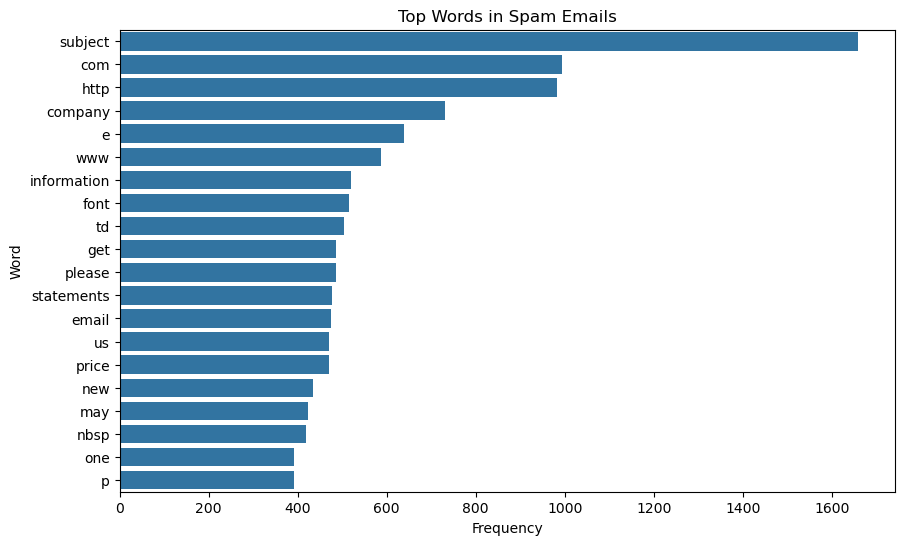

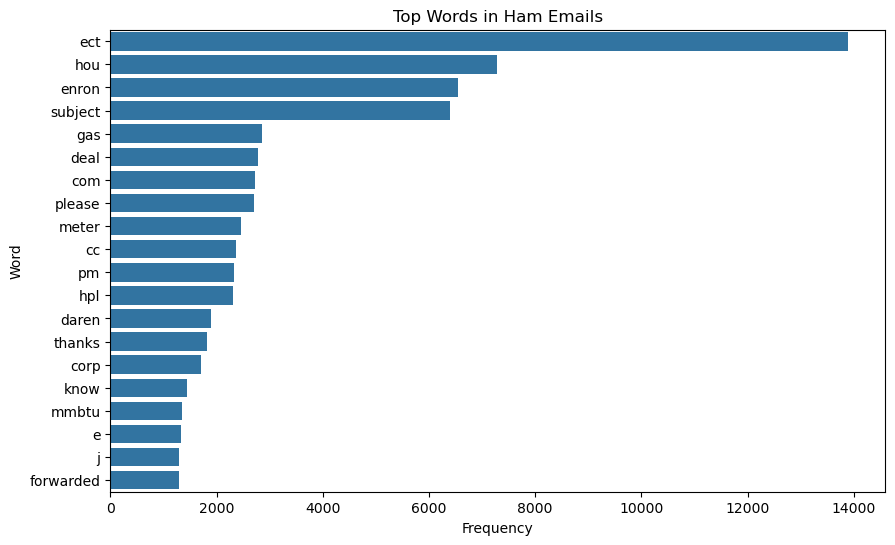


Visualizing Model Performance...


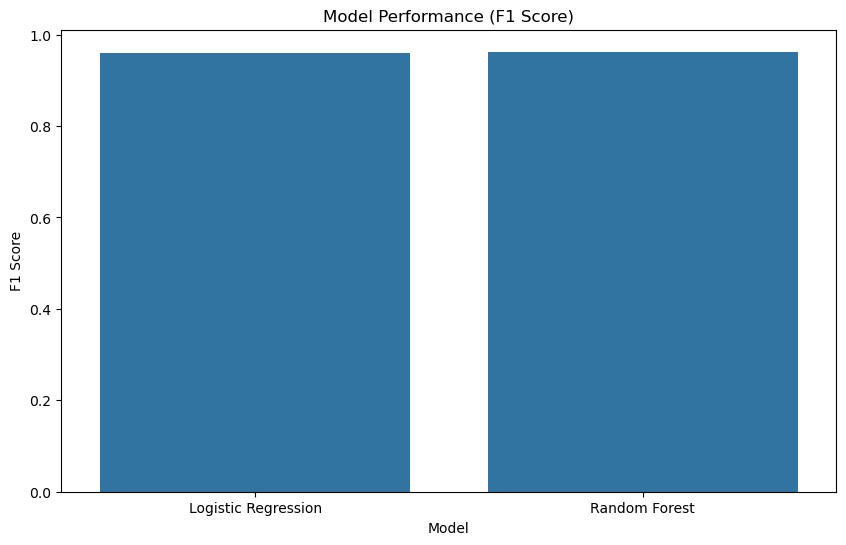

In [81]:
# Visualize Word Frequency
print("\nVisualizing Word Frequency...")
visualize_word_frequency(spam_emails, 'Top Words in Spam Emails')
visualize_word_frequency(ham_emails, 'Top Words in Ham Emails')

# Visualize Model Performance
print("\nVisualizing Model Performance...")
visualize_model_performance(models, scores)



Visualizing SVM and Gradient Boosting Performance...


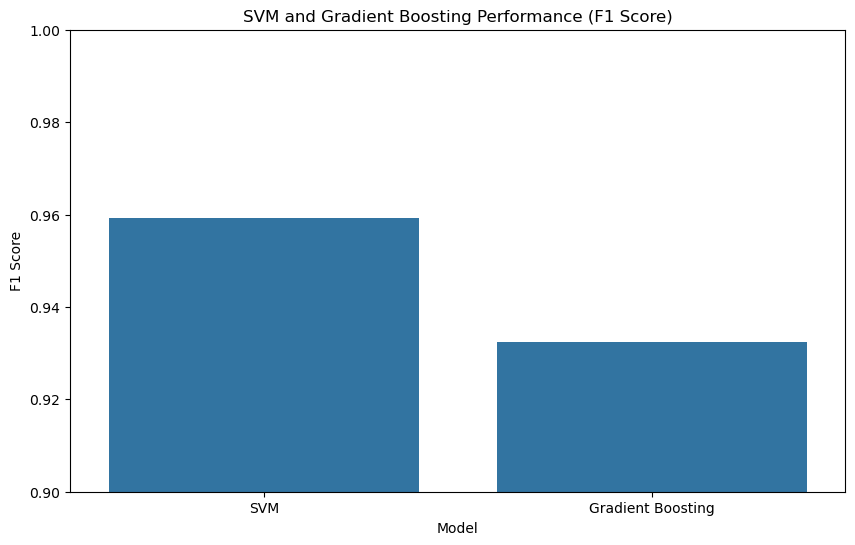

In [83]:
# Visualize SVM and Gradient Boosting Performance
def visualize_selected_model_performance(models, scores):
    """
    Visualize the performance of selected models (SVM and Gradient Boosting).
    :param models: List of model names (e.g., ["SVM", "Gradient Boosting"]).
    :param scores: Corresponding F1 scores for the selected models.
    """
    df = pd.DataFrame({'Model': models, 'F1 Score': scores})
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Model', y='F1 Score')
    plt.title('SVM and Gradient Boosting Performance (F1 Score)')
    plt.ylabel('F1 Score')
    plt.xlabel('Model')
    plt.ylim(0.9, 1)  # Adjust the range to focus on small differences
    plt.show()

# Select SVM and Gradient Boosting results for visualization
selected_models = ["SVM", "Gradient Boosting"]
selected_scores = [svm_score, gb_score]

# Visualize the results
print("\nVisualizing SVM and Gradient Boosting Performance...")
visualize_selected_model_performance(selected_models, selected_scores)



Generating Word Cloud for Spam Emails...


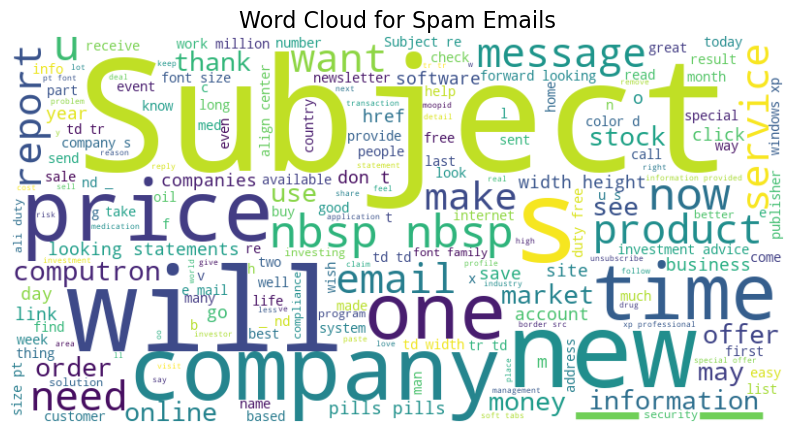


Generating Word Cloud for Ham Emails...


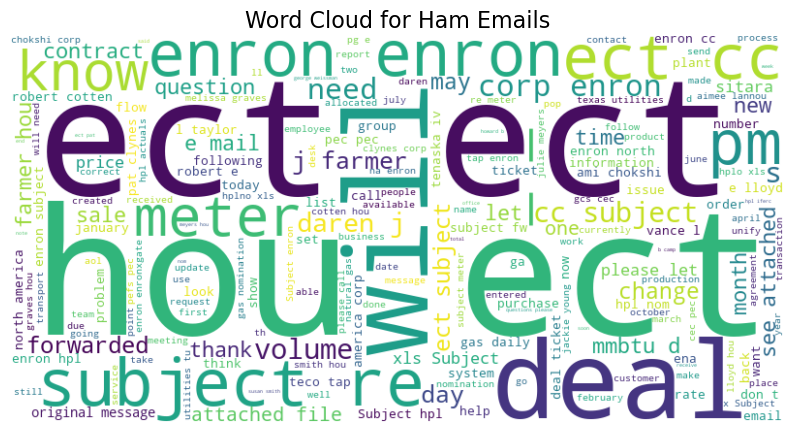

In [85]:
# wordcloud
from wordcloud import WordCloud

def generate_word_cloud(emails, title):
    """
    Generate a word cloud from a list of emails.
    :param emails: List of email texts.
    :param title: Title for the word cloud plot.
    """
    text = " ".join(emails)
    wordcloud = WordCloud(
        width=800, height=400, background_color="white", colormap="viridis"
    ).generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Generate Word Cloud for Spam Emails
print("\nGenerating Word Cloud for Spam Emails...")
generate_word_cloud(spam_emails, "Word Cloud for Spam Emails")

# Generate Word Cloud for Ham Emails
print("\nGenerating Word Cloud for Ham Emails...")
generate_word_cloud(ham_emails, "Word Cloud for Ham Emails")


Evaluating Model...


<Figure size 800x600 with 0 Axes>

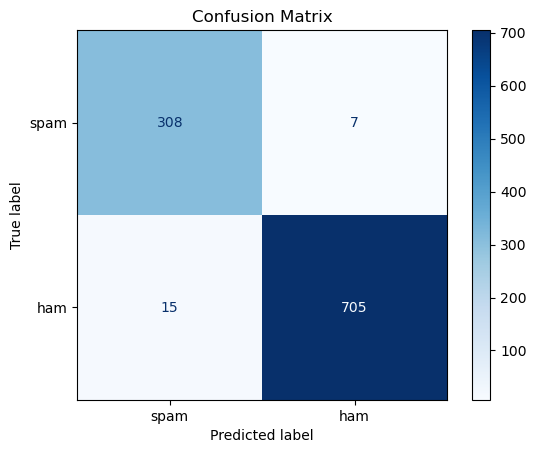

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, labels=["spam", "ham"]):
    """
    Plot confusion matrix for predicted results.
    :param y_true: True labels.
    :param y_pred: Predicted labels.
    :param labels: List of label names.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

# Example: Assume X_train, X_test, y_train, and y_test are defined
print("\nEvaluating Model...")
classifier = RandomForestClassifier()  # Replace with the classifier you are testing
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

# Plot Confusion Matrix
plot_confusion_matrix(y_test, y_pred)
